# What is done?

#### 1. Upsampling with forward and backward fill method upto 1 second frequency
#### 2. Downsampling to 10 second frequency
#### 3. Outlier detection and replacement

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join as jp
from warnings import warn

from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from logparser import *
from utils import *

Load the data:

In [2]:
data_init = convert_folder('sensors_data/')
# sort by DATE
data_init = data_init.sort_values(by='DATE')
# delete microseconds
data_init['DATE'] = data_init['DATE'].map(lambda x: x.replace(microsecond=0))
# remove lines with Missing Values (NaNs)
data_init = data_init[~data_init.isnull().sum(axis=1).astype(bool).values].reset_index(drop=True).copy()

126it [00:10,  9.28it/s]


In [3]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7517 entries, 0 to 7516
Data columns (total 9 columns):
DATE             7517 non-null datetime64[ns]
HEATER           7517 non-null float64
SMALL_LAMP       7517 non-null float64
BIG_LAMP         7517 non-null float64
EXT_T            7517 non-null float64
TOP_T            7517 non-null float64
MIDDLE_T         7517 non-null float64
ENERGY_PULSES    7517 non-null float64
ENERGY_WH        7517 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 528.6 KB


Upsample and downsample time-series:

In [11]:
ts_1s = pd.DataFrame({'DATE': pd.date_range(start=data_init['DATE'].min(),
                                            end=data_init['DATE'].max(),
                                            freq='1s')})

ts_10s = pd.DataFrame({'DATE': pd.date_range(start=data_init['DATE'].min(),
                                             end=data_init['DATE'].max(),
                                             freq='60s')})

In [12]:
data = pd.merge(ts_1s, data_init, how='left', on='DATE')
# forward fill to remove problem with 10s unmatching
data = data.ffill()
# downsample to 10s
data = pd.merge(ts_10s, data, how='left', on='DATE')

Detect outliers and replace them:

In [20]:
df = data.copy()

In [14]:
def replace_outliers(dataframe, column, window=5, sensitivity=10):
    dataframe = dataframe.copy()
    ts_mean = dataframe[column].rolling(window).mean().bfill().ffill()
    dataframe[column] = dataframe[column].mask(np.abs(ts_mean - dataframe[column]) > sensitivity, np.nan)
    dataframe[column] = dataframe[column].ffill()
    return dataframe

In [25]:
# T_3 has several outliers -> have to replace them
df = replace_outliers(df, 'EXT_T')
df = replace_outliers(df, 'TOP_T')
df = replace_outliers(df, 'MIDDLE_T')
df = replace_outliers(df, 'HEATER')

In [27]:
df_part = df[(df.DATE >= '2019-02-01') & (df.DATE <= '2019-02-03')]

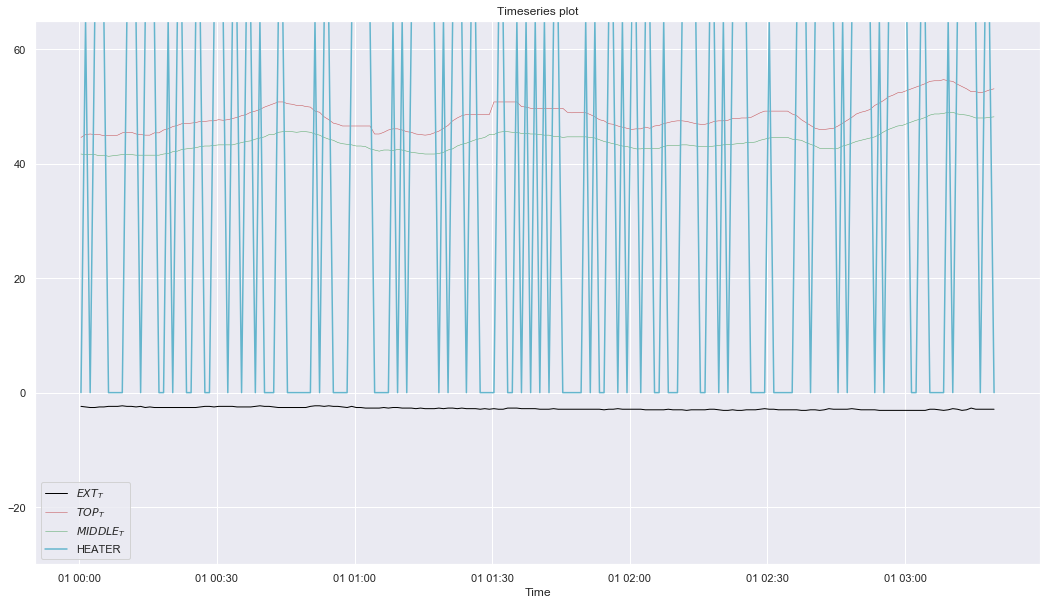

In [42]:
plot_ts(df_part[:200])

In [41]:
df.reset_index(drop=True).to_parquet('./data/dataset_cleared_v1.parquet')
# dataset_cleared_v1.parquet - 2nd version of data logging + clearning and outlier detection